***Савенкова Марина, гр. 932226***




#Задание

**Регрессор** (вариант чётный)

Оценка уровня потребления ресурсов домохозяйством. Набор данных DS_2019_public.csv. Описание атрибутов – файл recs2009_public_codebook.xlsx. Предсказываемый признак – один из атрибутов (использовать только один из): TOTALBTU, TOTALBTUSPH, TOTALBTUCOL, TOTALBTUWTH, TOTALBTURFG, TOTALBTUOTH (Примечание BTU – Британская тепловая единица BTU ≈ 252 калории).

1.	Выполнить загрузку и предварительную обработку данных из наборов.
2.	Разделить каждую выборку на обучающую, тестовую и валидационную.
3.	Произвести обучение набора нейросетевых архитектур, отличающихся разным набором параметров: число слоёв, количество нейронов в слоях, функции активации в слоях, процедур оптимизации: то есть подобрать архитектуры нейронных сетей, которые с одной стороны позволяют получить модели с лучшими метриками качества работы, с другой стороны не являются избыточными и не переобученными.
4.	Вычислить следующие метрики работы:
Для регрессора: MSE, MAE, R2 для всех полученных моделей.


#Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import missingno as msno

In [ ]:
import sklearn as skn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import metrics

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
# подключение диска

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/"

#Функции

In [ ]:
# функция для визуализации процесса обучения

def mae_and_loss_visualization(history, colors):

  clrs = [
      colors[1],
      colors[len(colors) - 1]
    ]

  train_acc = history.history['mae']
  val_acc = history.history['val_mae']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label='Training MAE', color = clrs[0])
  plt.plot(epochs, val_acc, label='Validation MAE', color = clrs[1])
  plt.title('Training and Validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_loss, label='Training Loss', color = clrs[0])
  plt.plot(epochs, val_loss, label='Validation Loss', color = clrs[1])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# вывод метрик MSE, MAE, R2

def print_metrics(model, X_test, y_test):

  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print('Mean squared error from neural network: ', mse)
  print('Mean absolute error from neural network: ', mae)
  print('R2 score from neural network: ', r2)

In [ ]:
# функция для визуализации тестовых и предсказанных значений

def prediction_visialization(model, X_test, y_test, colors):

  xx = y_test.index
  yy = y_test.values

  predictions = model.predict(X_test)

  fig = plt.figure()
  ax1 = fig.add_subplot(111)

  ax1.scatter(xx, yy, s = 15, c = colors[0], marker="*", label='test')
  ax1.scatter(xx, predictions, s = 15, c = colors[round(len(colors) / 2)], marker="+", label='predicted')
  plt.legend(loc='upper left')
  plt.show()

#Описание набора данных

В данной работе был использован набор данных DS_2019_public.csv, содержащий информацию о потреблении ресурсов домохозяйством. Описание атбритутов содержится в excel файле. Всего датасет содержит 121 признак.

В качестве целевой переменной была выбрана TOTALBTU - общее потребление (в тысячах BTU).

#Загрузка набора данных

Загрузим набор данных. Для этого сначала вычислим кодировку файла.

In [ ]:
import chardet

with open(path + 'DS_2019_public.csv', 'rb') as f:
    result = chardet.detect(f.read())

Передаем вычисленную кодировку в функцию reas_csv. Теперь преобразование проходит корректно.

In [ ]:
df = pd.read_csv(path + 'DS_2019_public.csv', encoding=result['encoding'], engine='python')

df

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,4,5,13,345.8,346,2695.625,9197.516,9198,820,26863,...,8,7179,5,264.409,264,7,0,0,5,2061.159
10871,1,3,9,13.005,13,97.497,332.665,333,521,49610,...,4,6471,6,75.569,76,5,0,1,5,566.544
10872,1,4,10,97.67,98,847.734,2892.504,2893,591,70626,...,-2,24391,6,250.313,250,8,0,1,1,2172.621
10873,1,8,23,12.834,13,135.687,462.975,463,432,49821,...,0,12416,6,175.135,175,5,0,1,1,1851.648


Выведем информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 121 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79), object(8)
memory usage: 10.0+ MB


Как видим, у нас есть данные типа 'object', которые необходимо будет закодировать.

Выведем имена столбцов.

In [ ]:
colnames = list(df.columns)
colnames

['Climate_Region_Pub',
 'DIVISION',
 'REPORTABLE_DOMAIN',
 'DOLELCOL',
 'TOTALDOLCOL',
 'KWHCOL',
 'BTUELCOL',
 'TOTALBTUCOL',
 'TOTALDOLSPH',
 'TOTALBTUSPH',
 'CELLAR',
 'NWEIGHT',
 'TOTHSQFT',
 'HEATHOME',
 'NUMPC',
 'DOLLAREL',
 'DOLELOTH',
 'CUFEETNGSPH',
 'BTUNGSPH',
 'DOLNGSPH',
 'TEMPHOME',
 'TOTCSQFT',
 'BTUFOSPH',
 'AIRCOND',
 'ELCOOL',
 'GALLONFOSPH',
 'WALLTYPE',
 'TOTALDOLOTH',
 'BTUFO',
 'GALLONFO',
 'DOLFOSPH',
 'DOLLARFO',
 'KWHSPH',
 'BTUELSPH',
 'FOWARM',
 'USEFO',
 'TOTUSQFT',
 'TOTALDOL',
 'NUMTHERM',
 'DOLELSPH',
 'CONCRETE',
 'CUFEETNG',
 'BTUNG',
 'GALLONFOOTH',
 'BTUFOOTH',
 'BEDROOMS',
 'FOWATER',
 'GALLONFOWTH',
 'BTUFOWTH',
 'DOLFOWTH',
 'GALLONKEROTH',
 'BTUKEROTH',
 'DOLKEROTH',
 'TOTUCSQFT',
 'TOTSQFT',
 'TOTSQFT_EN',
 'DOLNGWTH',
 'DOLFOOTH',
 'ELOTHER',
 'DOLLARNG',
 'FUELHEAT',
 'NOTMOIST',
 'GALLONKER',
 'BTUKER',
 'NUMCFAN',
 'FOILAUX',
 'TOTALBTU',
 'COOLTYPE',
 'DOOR1SUM',
 'DOLLARKER',
 'DOLLPOTH',
 'DOLELWTH',
 'KWHWTH',
 'BTUELWTH',
 'TOTROOMS',
 

#Анализ и предварительная обработка данных

In [ ]:
# настройка отображения графиков

palette = 'tab20b'

colors = sns.color_palette(palette).as_hex()[:]

## Кодирование категориальных переменных

Скопируем датасет в новый фрейм df_enc и закодируем категориальные признаки.

In [ ]:
df_enc = df.copy()

In [ ]:
# Кодирование категориальных факторов

for i in df_enc:
    if df_enc[i].dtypes == 'object':
       df_enc[i] = LabelEncoder().fit_transform(df_enc[i])
df_enc

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,1769,17,181.998,620.979,621,368,38606,...,-2,30110,2,1373,121,4,0,1,1,1310.220
1,1,1,1,5993,49,184.459,629.389,629,582,40248,...,2,7933,-2,5545,243,2,0,1,-2,915.664
2,1,3,7,105,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,3257,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,9609,85,5,0,1,5,346.468
4,1,4,10,5698,45,274.530,936.677,937,685,74100,...,3,14204,6,2933,151,6,0,1,5,920.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,4,5,13,4675,346,2695.625,9197.516,9198,820,26863,...,8,7179,5,5895,264,7,0,0,5,2061.159
10871,1,3,9,972,13,97.497,332.665,333,521,49610,...,4,6471,6,8931,76,5,0,1,5,566.544
10872,1,4,10,8718,98,847.734,2892.504,2893,591,70626,...,-2,24391,6,5674,250,8,0,1,1,2172.621
10873,1,8,23,723,13,135.687,462.975,463,432,49821,...,0,12416,6,3866,175,5,0,1,1,1851.648


#Отбор признаков

Произведем отбор признаков для обучения с помощью библиотеки feature_selector.

Ненужные признаки снижают скорость обучения модели, интерпретируемость и, главное, способность к обобщению. FeatureSelector – это специальный класс для отбора информативных признаков, написанный на языке Python, реализующий самые распространенные методы выборки. Его исходный код доступен на GitHub. Инструмент позволяет оценивать параметры по следующим характеристикам:

* высокий процент пропущенных значений;
* коллинеарность (сильная корреляция);
* нулевая важность в моделях, основанных на деревьях;
* низкая важность;
* единственное значение.


In [ ]:
# скопируем датасет в новый фрейм

features = df_enc.copy()

In [ ]:
# путь к библиотеке

path_m = path

In [ ]:
# добавляем путь

import sys

sys.path.insert(0, path_m)

In [ ]:
path_m

'/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/'

In [ ]:
# импортируем FeatureSelector

from feature_selector import FeatureSelector

In [ ]:
# данные и метки

train = df_enc.copy()
train_labels = train['TOTALBTU']

In [ ]:
# удаляем целевую переменную

train = train.drop(columns = ['TOTALBTU'])

In [ ]:
# создаем объект класса FeatureSelector
# на вход передаем данные и метки

fs = FeatureSelector(data = train, labels = train_labels)

## Коллинеарные признаки

Этот метод находит пары коллинеарных признаков на основе коэффициента корреляции Пирсона. Для каждой пары, превышающей указанный порог (в пересчете на абсолютное значение), он идентифицирует одну из переменных, подлежащих удалению.

Для каждой пары признак, который будет удален, является последним с точки зрения упорядочения столбцов во фрейме данных.

In [ ]:
# correlation_threshold - пороговое значение корреляции

fs.identify_collinear(correlation_threshold=0.975)

27 features with a correlation magnitude greater than 0.97.



/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/feature_selector.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)
/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение

Выведем признаки, порог корреляции которых выше указанного порога, отобранные для удаления.

In [ ]:
#список признаков для удаления

collinear_features = fs.ops['collinear']
collinear_features

['REPORTABLE_DOMAIN',
 'BTUELCOL',
 'TOTALBTUCOL',
 'BTUNGSPH',
 'ELCOOL',
 'GALLONFOSPH',
 'BTUFO',
 'GALLONFO',
 'DOLLARFO',
 'BTUELSPH',
 'BTUNG',
 'BTUFOOTH',
 'BTUFOWTH',
 'DOLFOWTH',
 'BTUKEROTH',
 'DOLKEROTH',
 'TOTSQFT_EN',
 'DOLFOOTH',
 'BTUKER',
 'DOLLARKER',
 'BTUELWTH',
 'BTUKERSPH',
 'BTULPSPH',
 'BTULP',
 'BTULPOTH',
 'DOLKERSPH',
 'BTUEL']

Выведем количество обнаруженных признаков.

In [ ]:
print("The number of collinear features: ", len(collinear_features))

The number of collinear features:  27


Выведем значение корреляции для признаков. Как видно, встречаются признаки со значением корреляции, равном единице.

In [ ]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,REPORTABLE_DOMAIN,DIVISION,0.979677
1,BTUELCOL,KWHCOL,1.000000
2,TOTALBTUCOL,KWHCOL,1.000000
3,TOTALBTUCOL,BTUELCOL,1.000000
4,BTUNGSPH,CUFEETNGSPH,1.000000


##Признаки нулевой важности

Этот метод основан на модели машинного обучения для определения признаков, которые необходимо удалить. Следовательно, требуется контролируемая задача обучения с метками. Метод работает путем определения важности объектов с помощью машины повышения градиента, реализованной в библиотеке LightGBM.

Чтобы уменьшить дисперсию в вычисляемых значениях признаков, модель обучается по умолчанию 10 раз. Модель также по умолчанию обучается с ранней остановкой с использованием набора проверок (15% обучающих данных), чтобы определить оптимальное количество оценщиков для обучения.

Методу identify_zero_importance могут быть переданы следующие параметры:

* task: либо классификация, либо регрессия. Метрика и метки должны соответствовать задаче
* eval_metric: показатель, используемый для ранней остановки (например, auc для классификации или l2 для регрессии). Чтобы просмотреть список доступных показателей, обратитесь к документации LightGBM
* n_iterations: количество тренировочных запусков. Значения функций усредняются по результатам обучения (по умолчанию = 10).
* _early_stopping: следует ли использовать раннюю остановку при обучении модели (по умолчанию = True). Ранняя остановка останавливает обучение оценщиков (деревьев решений), когда производительность набора проверок больше не снижается для указанного числа оценок (по умолчанию в этой реализации 100). Ранняя остановка - это форма регуляризации, используемая для предотвращения переобучения обучающим данным


Предостережение: в отличие от других методов, значения признаков из модели недетерминированы (имеют небольшую случайность). Результаты выполнения этого метода могут меняться при каждом его запуске.

In [ ]:
# отбор признаков

fs.identify_zero_importance(task = 'regression', eval_metric = 'l2',
                            n_iterations = 10, _early_stopping = True)

Training Gradient Boosting Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15512
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 113
[LightGBM] [Info] Start training from score 90527.354943
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l2: 5.25168e+07
[200]	valid_0's l2: 4.69011e+07
[300]	valid_0's l2: 4.465e+07
[400]	valid_0's l2: 4.38028e+07
Early stopping, best iteration is:
[410]	valid_0's l2: 4.36289e+07
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15467
[LightGBM] [Info] Number of data points 

Выведем признаки с нулевой важностью.

In [ ]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['ELCOOL',
 'UGWARM',
 'WDWATER',
 'BTUKEROTH',
 'HEATHOME',
 'SOLARAUX',
 'AIRCOND',
 'DOLKEROTH',
 'GALLONFOOTH',
 'UGWATER',
 'ELWATER',
 'BTUFOOTH',
 'FOWARM',
 'USEFO',
 'ELOTHER',
 'USENG',
 'DOLFOOTH',
 'SOLWARM']

И количество zero importance признаков.

In [ ]:
print('The number of zero_importance_features: ',len(zero_importance_features))

The number of zero_importance_features:  18


## Удаление признаков

Удалим обнаруженные ранее признаки с высокой корреляцией и нулевой важностью.

In [ ]:
train_removed = fs.remove(methods = ['collinear', 'zero_importance'], keep_one_hot=False)

Removed 40 features including one-hot features.


Выведем оставшиеся признаки и их количество.

In [ ]:
list(train_removed.columns)

['Climate_Region_Pub',
 'DIVISION',
 'DOLELCOL',
 'TOTALDOLCOL',
 'KWHCOL',
 'TOTALDOLSPH',
 'TOTALBTUSPH',
 'CELLAR',
 'NWEIGHT',
 'TOTHSQFT',
 'NUMPC',
 'DOLLAREL',
 'DOLELOTH',
 'CUFEETNGSPH',
 'DOLNGSPH',
 'TEMPHOME',
 'TOTCSQFT',
 'BTUFOSPH',
 'WALLTYPE',
 'TOTALDOLOTH',
 'DOLFOSPH',
 'KWHSPH',
 'TOTUSQFT',
 'TOTALDOL',
 'NUMTHERM',
 'DOLELSPH',
 'CONCRETE',
 'CUFEETNG',
 'BEDROOMS',
 'FOWATER',
 'GALLONFOWTH',
 'GALLONKEROTH',
 'TOTUCSQFT',
 'TOTSQFT',
 'DOLNGWTH',
 'DOLLARNG',
 'FUELHEAT',
 'NOTMOIST',
 'GALLONKER',
 'NUMCFAN',
 'FOILAUX',
 'COOLTYPE',
 'DOOR1SUM',
 'DOLLPOTH',
 'DOLELWTH',
 'KWHWTH',
 'TOTROOMS',
 'GALLONKERSPH',
 'TOTALBTUOTH',
 'GALLONLPSPH',
 'NCOMBATH',
 'OVEN',
 'EQUIPM',
 'STORIES',
 'GALLONLP',
 'LGT1',
 'FUELH2O',
 'GALLONLPOTH',
 'TVCOLOR',
 'CUFEETNGOTH',
 'BTUNGOTH',
 'KWHOTH',
 'TOTALDOLWTH',
 'DOLLPSPH',
 'YEARMADE',
 'BTUELOTH',
 'KWH',
 'DOLLARLP',
 'CUFEETNGWTH',
 'BTUNGWTH',
 'SDESCENT',
 'TEMPGONE',
 'LGT1EE',
 'TOTALBTUWTH',
 'ROOFTYPE',
 'DO

In [ ]:
print('The number of selected features: ', len(train_removed.columns))

The number of selected features:  80


##Признаки с константными значениями

Найдем в отобранных признаках также признаки с константными значениями и признаки с малым отклонением.

In [ ]:
# зададим порог
threshold = 0.85

columns_with_constant_values = []

for c in train_removed.columns:

  value_frequencies = train_removed[c].value_counts(normalize=True)
  #print(value_frequencies)
  if value_frequencies.max() >= 0.85:
    columns_with_constant_values.append(c)

print(columns_with_constant_values)
print(len(columns_with_constant_values))

['BTUFOSPH', 'DOLFOSPH', 'FOWATER', 'GALLONFOWTH', 'GALLONKEROTH', 'NOTMOIST', 'GALLONKER', 'FOILAUX', 'DOLLPOTH', 'GALLONKERSPH', 'GALLONLPSPH', 'OVEN', 'GALLONLP', 'GALLONLPOTH', 'DOLLPSPH', 'DOLLARLP', 'SDESCENT']
17


Удалим найденные признаки.

In [ ]:
without_const_v_df = train_removed.copy()

for col in columns_with_constant_values:
    if col in without_const_v_df.columns:
        del without_const_v_df[col]
        #print(col)


И выведем итоговое количество признаков для обучения.

In [ ]:
print('The number of features: ', len(without_const_v_df.columns))

The number of features:  63


#Разделение данных на выборки

In [ ]:
# отобранные признаки

#selected_X = train_removed.copy()

selected_X = without_const_v_df.copy()

In [ ]:
# целевая переменная

y = df_enc['TOTALBTU']

In [ ]:
# выполянем стандартизацию признаков

st_scaler = StandardScaler()
selected_X = st_scaler.fit_transform(selected_X)

In [ ]:
# выборки для обучения

X_train, X_test, y_train, y_test = train_test_split(
  selected_X,
  y,
  train_size=0.7,
  random_state=0
)

In [ ]:
# выборки для тестирования и валидации

X_test, X_val, y_test, y_val = train_test_split(
  X_test,
  y_test,
  train_size=0.5,
  random_state=0
)

#Наборы нейросетевых архитектур

##Модель №2

Увеличим число нейронов в слоях и добавим ещё один слой с функцией активации relu.

In [ ]:
model_2 = Sequential()

model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='linear'))

###Настройка параметров обучения

Параметры обучения оставим такими же, как и у предыдущей модели.

In [ ]:
model_2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
  )

###Обучение модели

Обучим модель на 50 эпохах.

In [ ]:
regr_model_2_checkpoint_filepath = path + 'models/' + 'regrModel_2.hdf5'

checkpoint_cb = ModelCheckpoint(
                  filepath = regr_model_2_checkpoint_filepath,
                  monitor = 'val_mae',
                  verbose = 1,
                  mode = 'max',
                  save_best_only = True
              )

callbacks = [
    checkpoint_cb
]

In [ ]:
history_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_val,y_val),
    callbacks = callbacks,
    epochs = 50
  )

Epoch 1/50
751/762 [============================>.] - ETA: 0s - loss: 95939.3359 - mae: 221.8202 - mse: 95939.3359
Epoch 1: val_mae improved from -inf to 225.58691, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/models/regrModel_2.hdf5
762/762 [==============================] - 2s 3ms/step - loss: 96010.7188 - mae: 221.9999 - mse: 96010.7188 - val_loss: 211867.7500 - val_mae: 225.5869 - val_mse: 211867.7188
Epoch 2/50
 59/762 [=>............................] - ETA: 1s - loss: 95667.8906 - mae: 228.9572 - mse: 95667.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


755/762 [============================>.] - ETA: 0s - loss: 331424.0312 - mae: 287.5241 - mse: 331424.0000
Epoch 2: val_mae did not improve from 225.58691
762/762 [==============================] - 2s 2ms/step - loss: 328979.4375 - mae: 286.2096 - mse: 328979.4062 - val_loss: 177320.7812 - val_mae: 158.5289 - val_mse: 177320.7812
Epoch 3/50
741/762 [============================>.] - ETA: 0s - loss: 55029.3438 - mae: 167.1380 - mse: 55029.3438
Epoch 3: val_mae improved from 225.58691 to 254.53093, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 4/models/regrModel_2.hdf5
762/762 [==============================] - 2s 2ms/step - loss: 55297.8203 - mae: 167.7538 - mse: 55297.8203 - val_loss: 223634.1406 - val_mae: 254.5309 - val_mse: 223634.1406
Epoch 4/50
742/762 [============================>.] - ETA: 0s - loss: 99412.5234 - mae: 210.9268 - mse: 99412.5234  
Epoch 4: val_mae did not improve from 254.53093
762/762 [==============================] 

###Оценка модели

Выведем метрики.

In [ ]:
print_metrics(model_2, X_test, y_test)

51/51 [==============================] - 0s 2ms/step
Mean squared error from neural network:  21895.036639603422
Mean absolute error from neural network:  101.45518440326104
R2 score from neural network:  0.9999919144048598


Визуализируем процесс обучения.

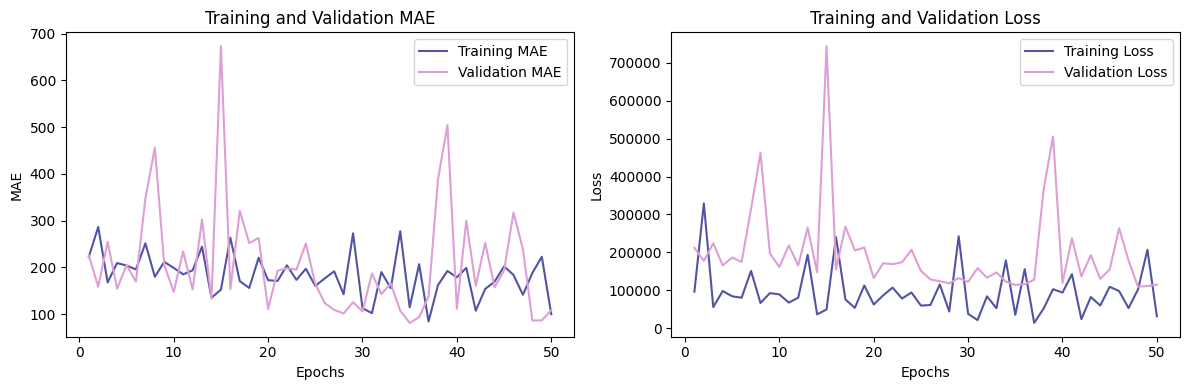

In [ ]:
mae_and_loss_visualization(history_2, colors)

Построим на графике тестовые и предсказанные значения.

51/51 [==============================] - 0s 1ms/step


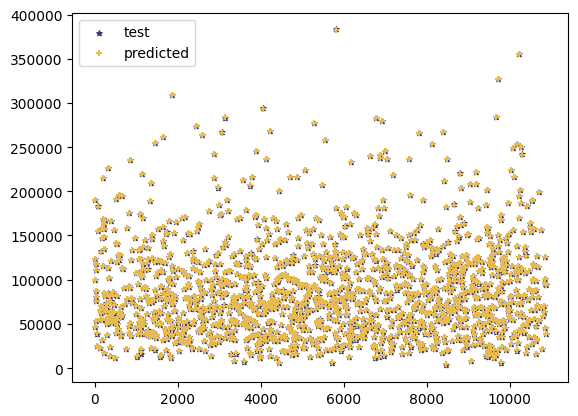

In [ ]:
prediction_visialization(model_2, X_test, y_test, colors)

Значения на графике практически совпадают, а коэффициент детерминации очень близок к единице.

# Расчет значений Шепли

In [ ]:
!pip install shap tf-explain pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 18.6 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
# загрузка модели
model = tf.keras.models.load_model(path + 'models/' + 'regrModel_2.hdf5')

In [ ]:
# размер подвыборки
sample_size = 100

X_train_sample = shap.sample(X_train, sample_size)

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train_sample)

4/4 [==============================] - 1s 28ms/step


In [ ]:
shap_values = explainer.shap_values(X_test, nsamples=100)

  0%|          | 0/1631 [00:00<?, ?it/s]

313/313 [==============================] - 0s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.770e+01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 68 iterations, alpha=4.488e+00, previous alpha=4.269e+00, with an active set of 43 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.017e+03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=6.618e+02, previous alpha=3.690e+02, with an active set of 31 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.132e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=6.201e+01, previous alpha=6.201e+01, with an active set of 40 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.770e+01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 90 iterations, alpha=3.319e+00, previous alpha=3.319e+00, with an active set of 49 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.445e+01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.784e+01, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=5.507e+00, previous alpha=5.436e+00, with an active set of 26 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.885e+03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=6.729e+02, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=6.110e+02, previous alpha=6.105e+02, with an active set of 23 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.562e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 76 iterations, alpha=7.973e+01, previous alpha=7.973e+01, with an active set of 39 regressors.


313/313 [==============================] - 1s 2ms/step


Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.848e+01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.453e+01, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.335e+01, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=8.906e+00, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the res

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(shap_values)

[array([[ 1.19119587e+02,  1.50194599e+01,  0.00000000e+00, ...,
         5.86515299e+01, -5.43960089e+01, -1.71906542e+03],
       [-2.18118032e+02, -1.79830656e+02,  3.84969815e+01, ...,
         0.00000000e+00, -3.56277645e+01, -1.97363870e+03],
       [ 3.02343443e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  7.39766660e+01, -1.85094773e+03],
       ...,
       [ 0.00000000e+00,  7.50338668e+01, -7.68054551e+01, ...,
         1.29626964e+00,  6.08675287e+01, -2.02201113e+03],
       [-6.63013279e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  5.08034258e+01, -8.17884179e+02],
       [-4.34392175e+01, -1.40928057e+02,  6.28345323e-01, ...,
         0.00000000e+00,  9.66454959e+01,  1.80239939e+03]])]


In [ ]:
np.save(path + 'saved_shap_values', shap_values)

### Оценка важности признаков как среднее значение абсолютных значений

In [ ]:
selected_X = without_const_v_df.copy()
y = df_enc['TOTALBTU']

In [ ]:
# Вычисляем среднее абсолютное значение Шепли для каждого признака по всем классам
mean_shap_values = np.abs(shap_values).mean(axis=1)

# Создаем DataFrame для наглядности
feature_names = selected_X.columns
shap_df = pd.DataFrame(mean_shap_values, columns=feature_names)

# Выводим DataFrame
shap_df

,Climate_Region_Pub,DIVISION,DOLELCOL,TOTALDOLCOL,KWHCOL,TOTALDOLSPH,TOTALBTUSPH,CELLAR,NWEIGHT,TOTHSQFT,...,BTUNGWTH,TEMPGONE,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,DRYRFUEL,KWHRFG
0,41.510135,33.303061,45.217929,42.41925,4802.881929,36.099094,27174.899244,29.413302,33.761063,33.617654,...,152.932092,55.335696,66.87755,8502.964096,40.337814,36.497512,30.437977,28.532886,51.613631,1702.122632


### Визуализировать значения Шепли для наборов данных и полученные значения важности

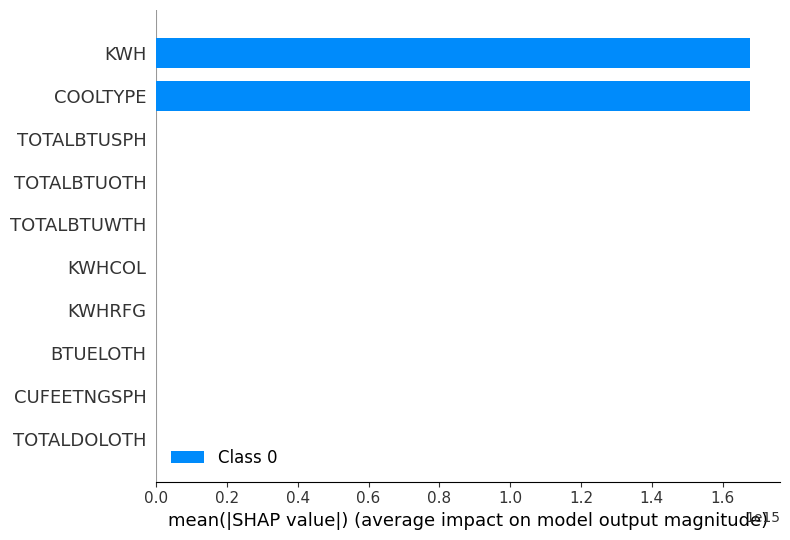

In [ ]:
# Визуализация с помощью summary_plot для 10 самых важных признаков
shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=10)

In [ ]:
shap_values_array = np.array(shap_values[0])

# Calculate the average absolute Shapley values for each feature
mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

# Get the indexes of the 10 most important features
top_indices = np.argsort(-mean_abs_shap_values)[:10]

# Get the names of the 10 most important signs
top_feature_names = selected_X.columns[top_indices]
top_feature_names

Index(['TOTALBTUSPH', 'TOTALBTUOTH', 'TOTALBTUWTH', 'KWHCOL', 'KWH', 'KWHRFG',
       'BTUELOTH', 'CUFEETNGSPH', 'TOTALDOLOTH', 'CUFEETNG'],
      dtype='object')

In [ ]:
shap_values[0]

array([[  120.49975435,    -7.22661531,   -17.40839163, ...,
          -17.06219409,  -144.06695199, -1660.7291754 ],
       [  -88.20304086,   191.52029385,     0.        , ...,
          -59.45022934,    36.66290279, -1994.67100065],
       [    0.        ,     0.        ,     0.        , ...,
           21.96564638,    55.46605363, -1781.81088532],
       ...,
       [    0.        ,    45.53550594,   -29.41103162, ...,
          -51.72447827,     0.        , -1919.01350661],
       [   43.58792914,   -20.94362255,   172.46911116, ...,
            0.        ,    53.92859423,  -940.27310997],
       [  -58.23319441,   -14.15303096,    -9.7740385 , ...,
         -136.38041064,   -15.14077971,  1790.63411355]])

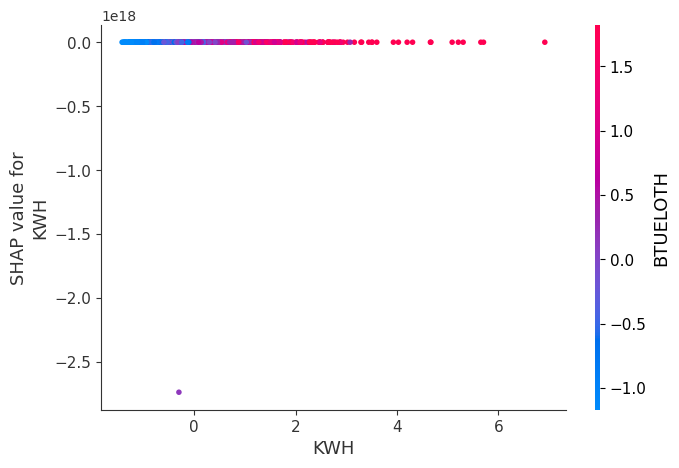

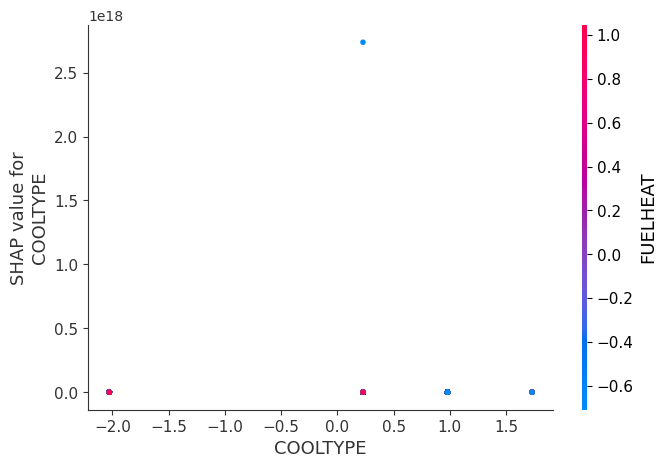

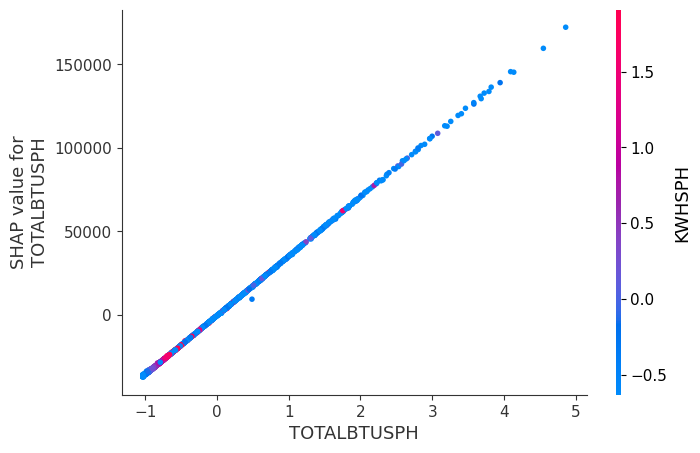

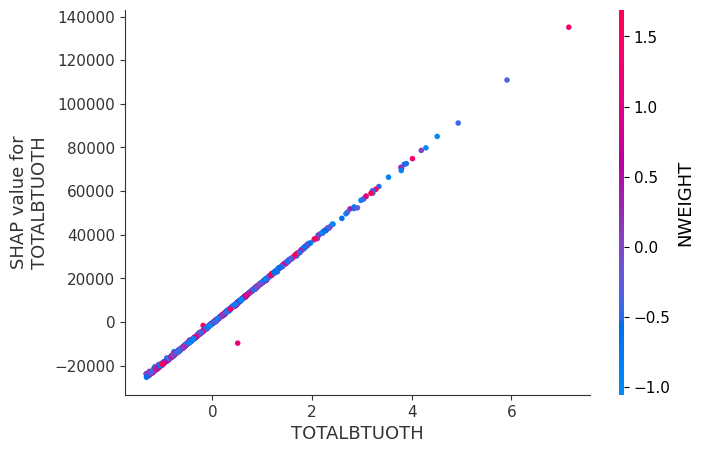

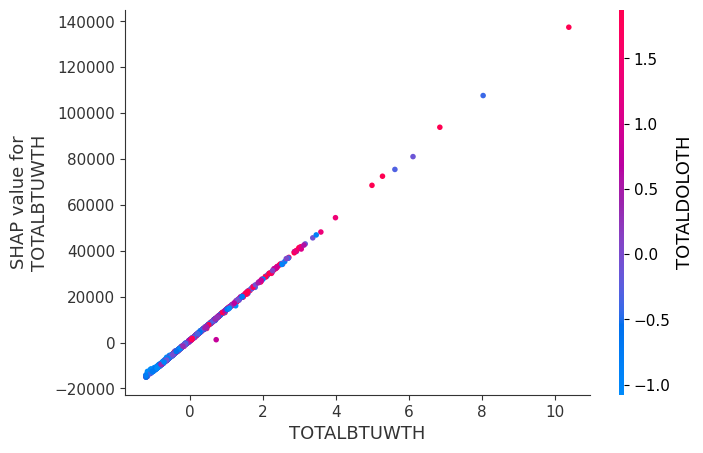

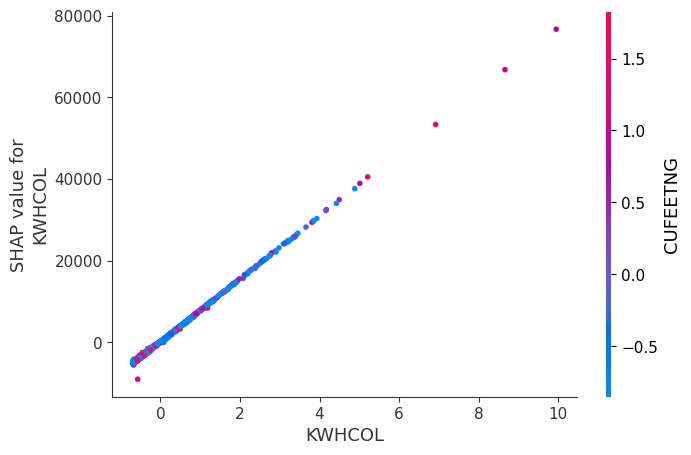

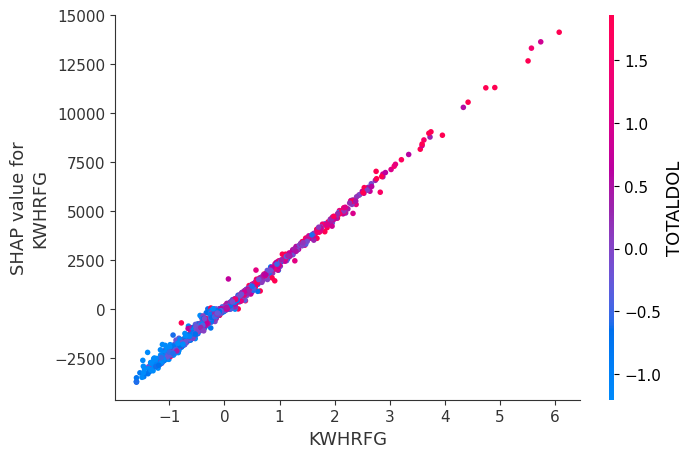

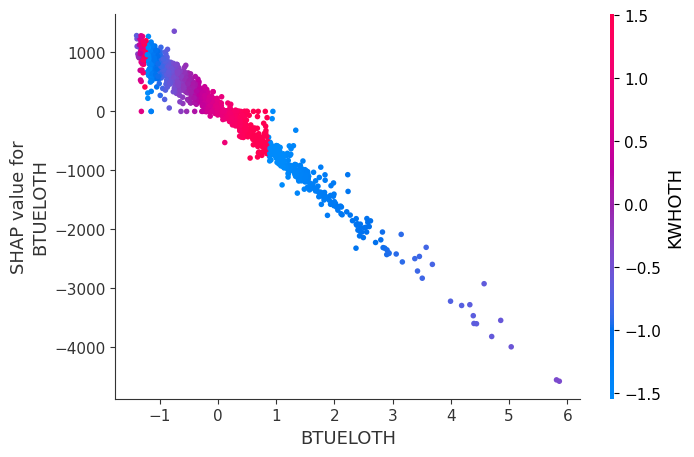

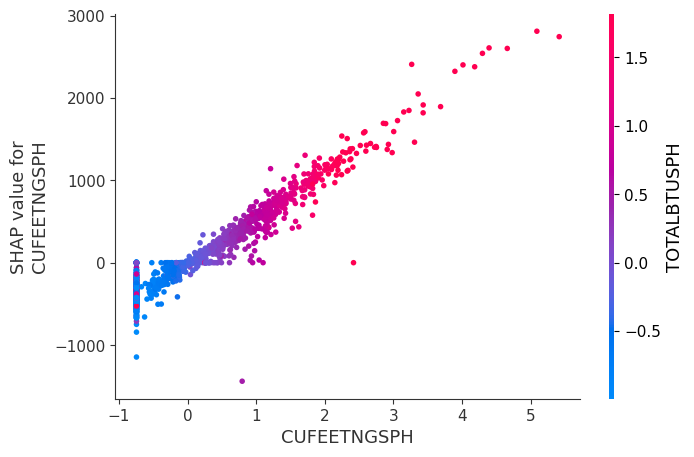

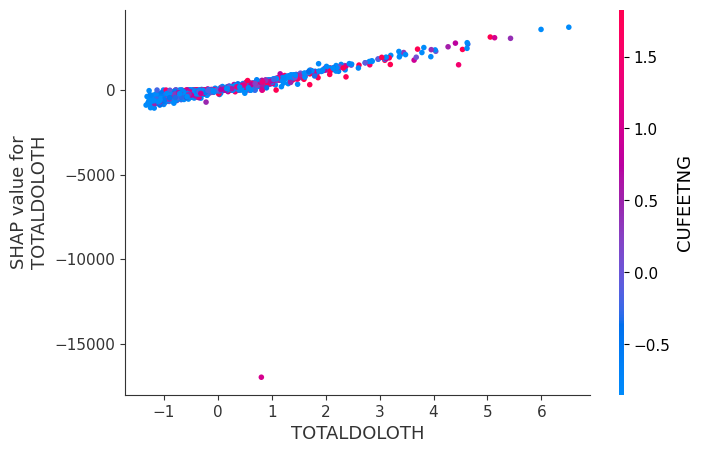

In [ ]:
# Creating a dependence_plot for each attribute
for feature_name in top_feature_names:
    shap.dependence_plot(feature_name, shap_values_array, X_test, feature_names=feature_names)

##Анализ примеров

In [ ]:
sample_indices = [0, 1, 2]
selected_examples = selected_X.iloc[sample_indices]
selected_examples

,Climate_Region_Pub,DIVISION,DOLELCOL,TOTALDOLCOL,KWHCOL,TOTALDOLSPH,TOTALBTUSPH,CELLAR,NWEIGHT,TOTHSQFT,...,BTUNGWTH,TEMPGONE,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,DRYRFUEL,KWHRFG
0,5,10,1769,17,181.998,368,38606,0,8599.172010,2736,...,30109.973,70,-2,30110,2,1373,121,4,1,1310.220
1,1,1,5993,49,184.459,582,40248,-2,8969.915921,528,...,7932.978,60,2,7933,-2,5545,243,2,-2,915.664
2,1,3,105,101,1063.022,425,40196,0,18003.639600,1623,...,0.000,55,-2,6440,5,3257,159,7,5,1670.534


  0%|          | 0/1 [00:00<?, ?it/s]

6794/6794 [==============================] - 11s 2ms/step


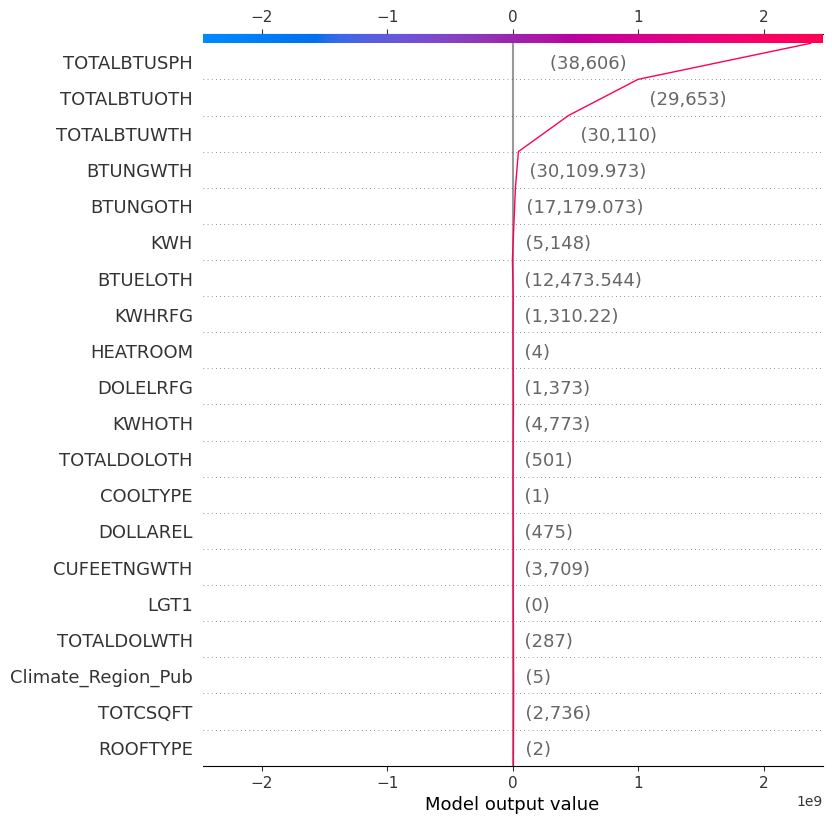

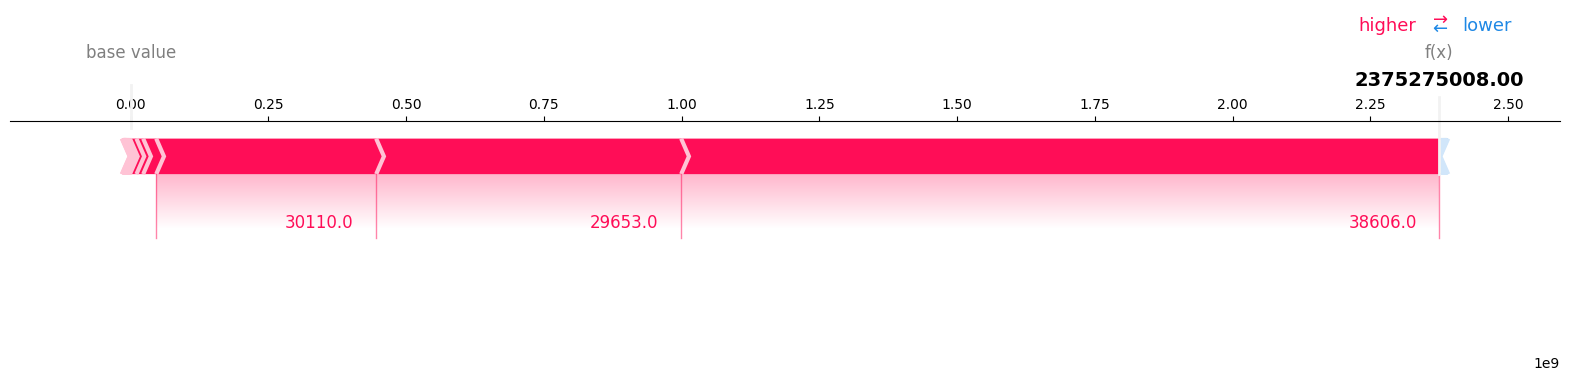

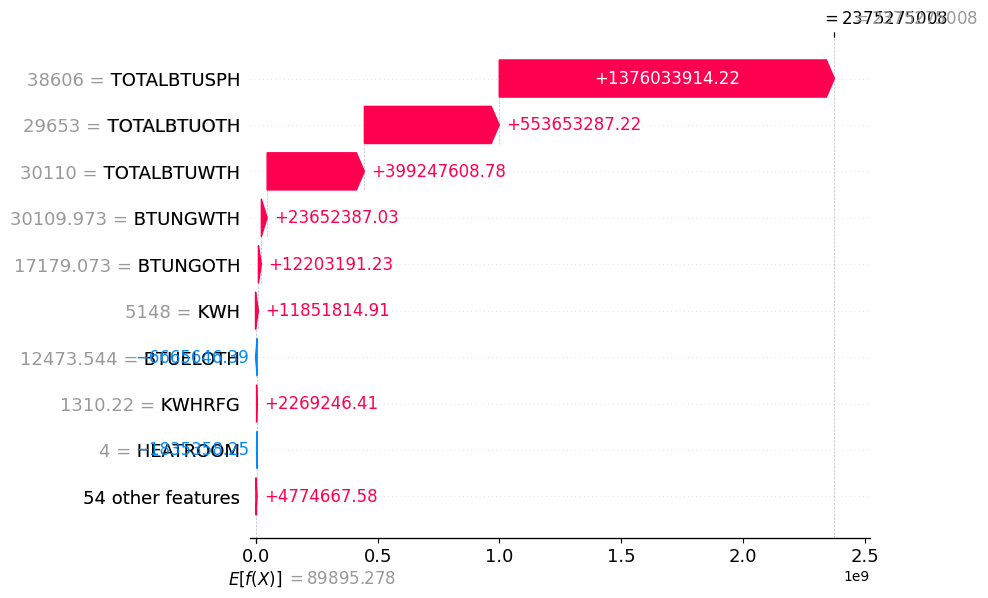

  0%|          | 0/1 [00:00<?, ?it/s]

6794/6794 [==============================] - 10s 1ms/step


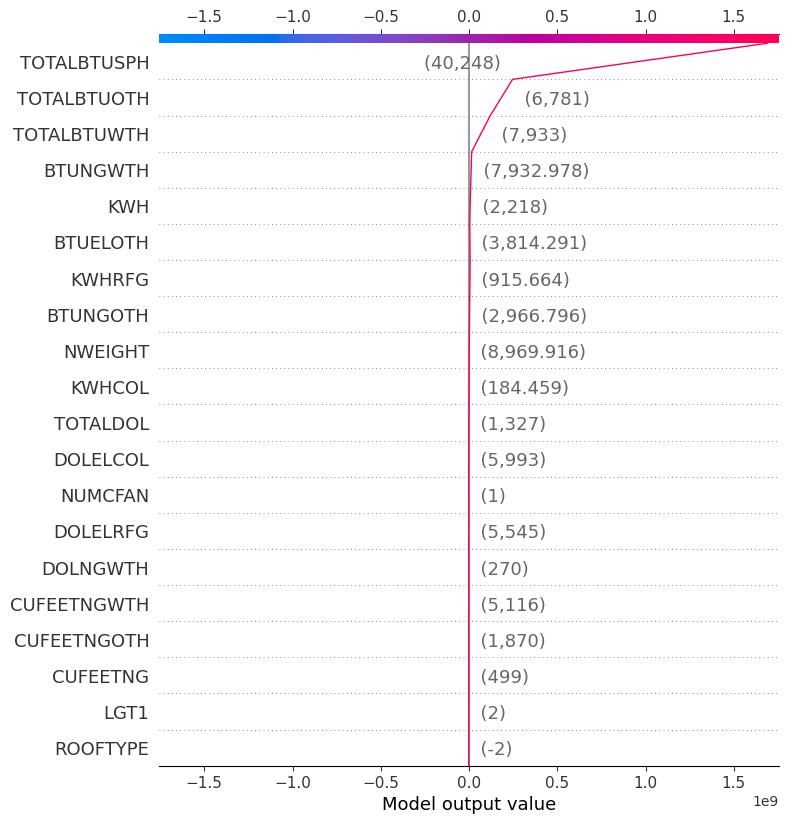

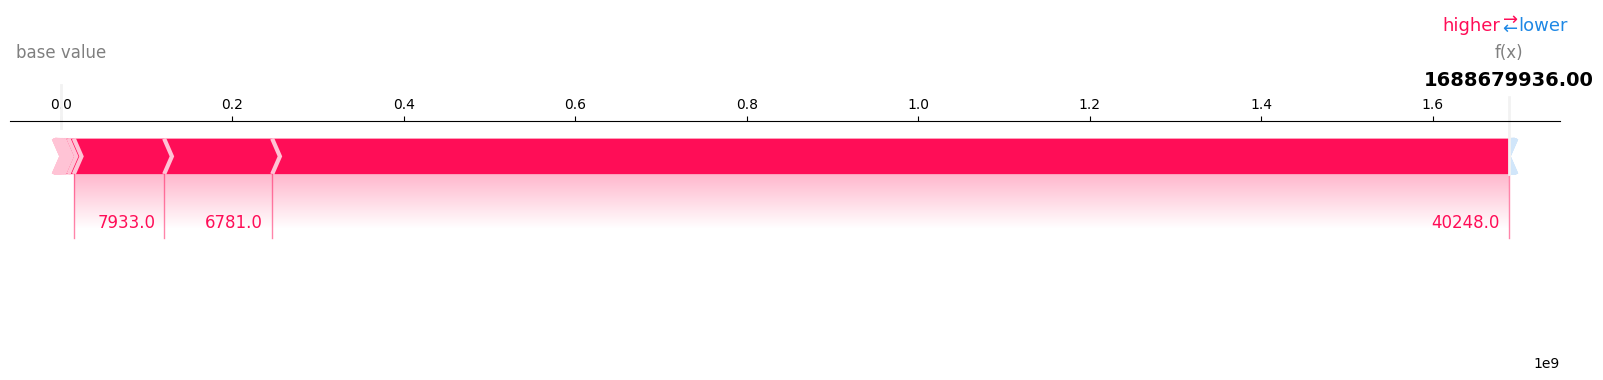

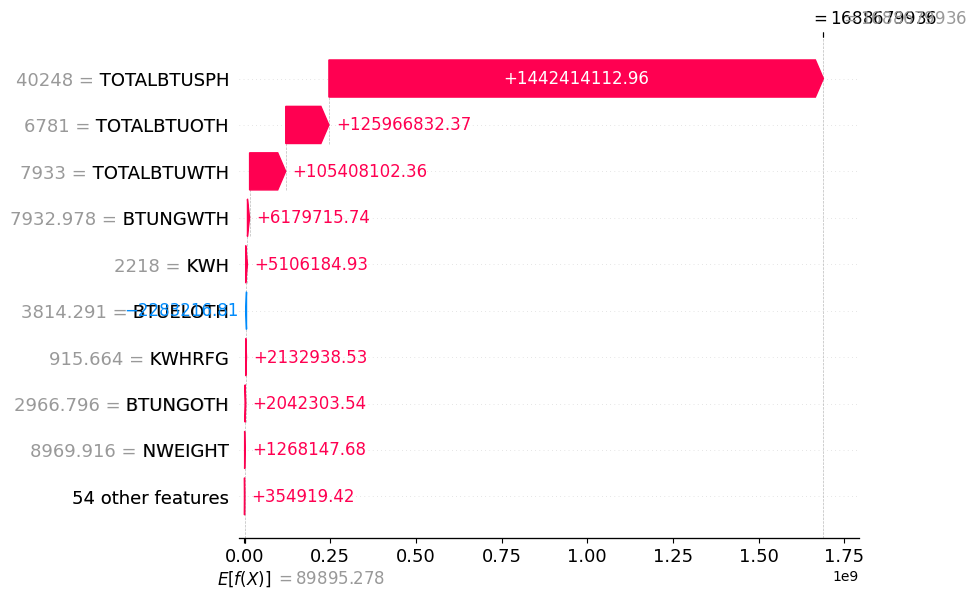

  0%|          | 0/1 [00:00<?, ?it/s]

6794/6794 [==============================] - 15s 2ms/step


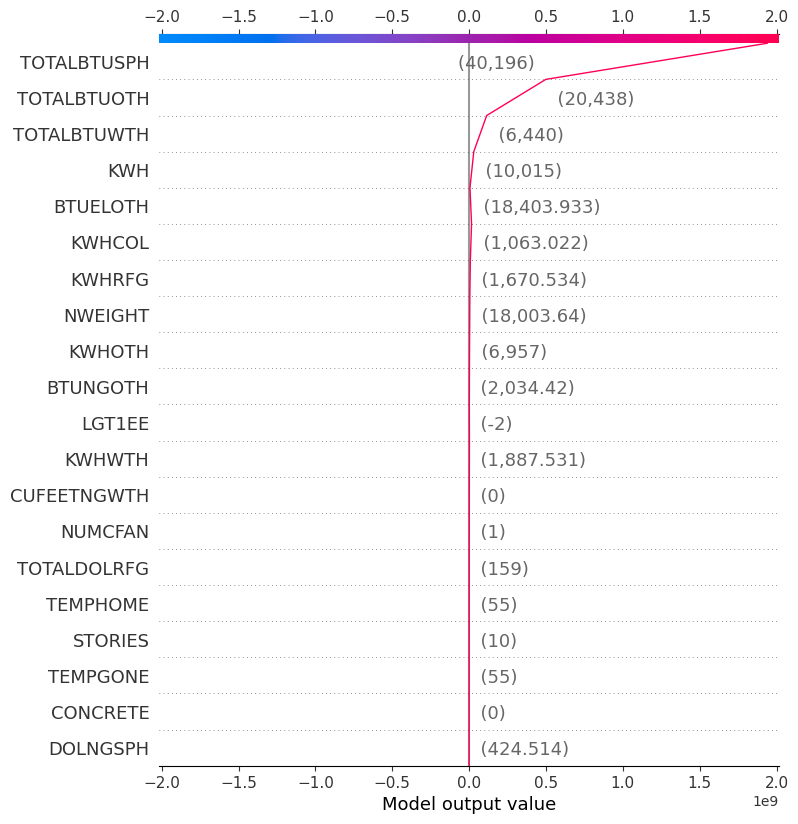

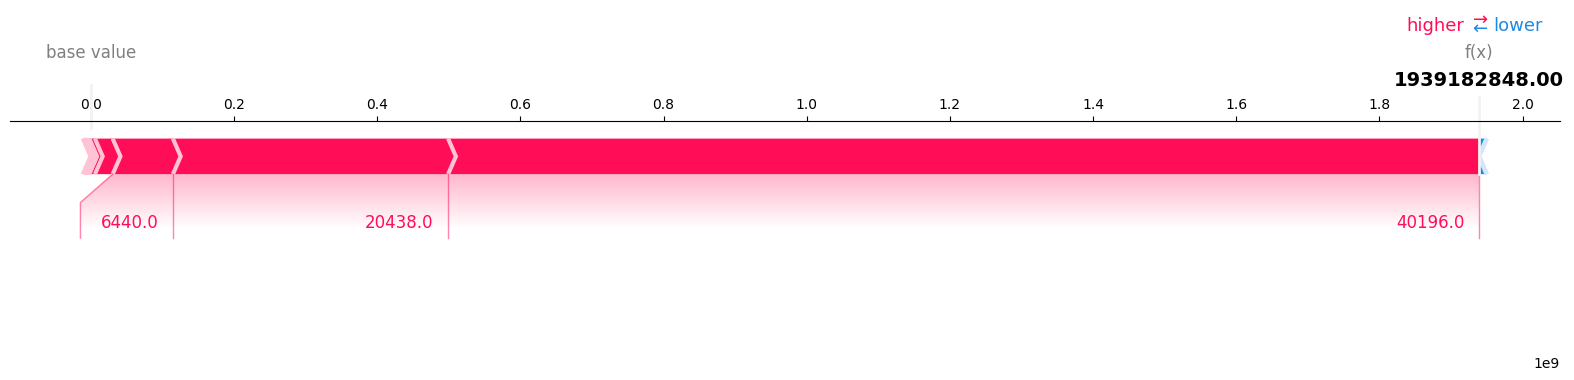

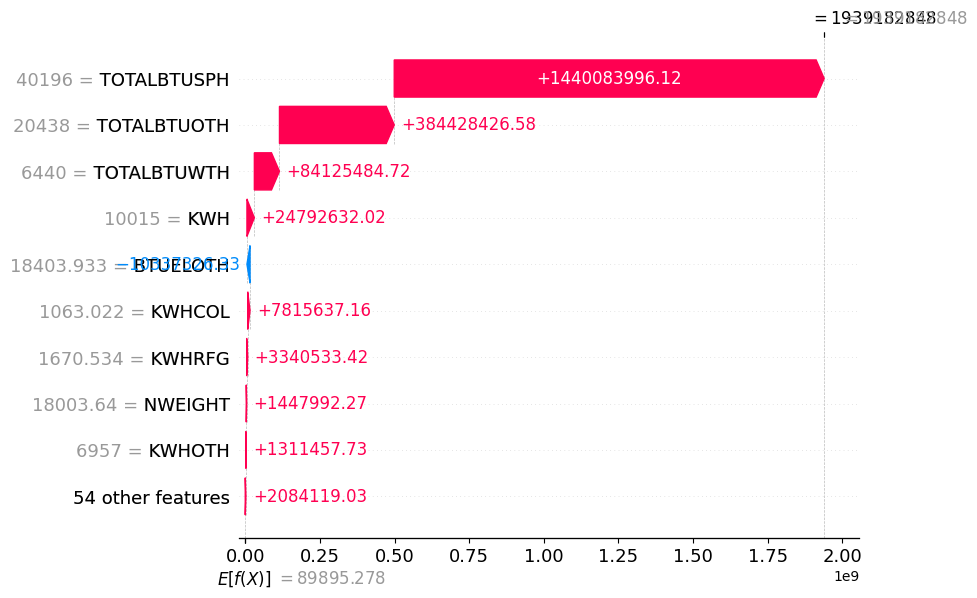

In [ ]:
for i in sample_indices:
    # Getting the data for the current example
    sample_data = selected_examples.iloc[i].values.reshape(1, -1)

    # Calculating the Shapley values for this example
    shap_values_sample = explainer.shap_values(sample_data)

    # Creating an Explanation object for the waterfall_plot
    shap_explanation = shap.Explanation(values=shap_values_sample[0][0],
                                        base_values=explainer.expected_value,
                                        data=sample_data[0],
                                        feature_names=feature_names)

    # Creating a decision_plot
    shap.decision_plot(explainer.expected_value, shap_values_sample[0][0], selected_examples.iloc[i])
    plt.show()

    # Creating force_plot
    shap.force_plot(explainer.expected_value, shap_values_sample[0][0], selected_examples.iloc[i].values, matplotlib=True)
    plt.show()

    # Creating a waterfall_plot
    shap.waterfall_plot(shap_explanation)
    plt.show()


##Построение графиков частичной зависимости

238/238 [==============================] - 1s 2ms/step


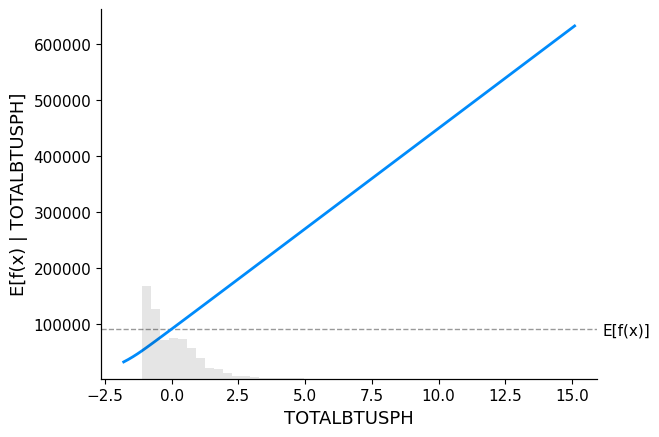

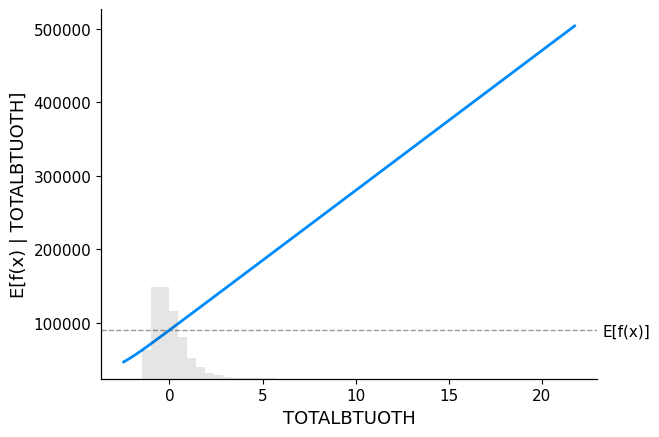

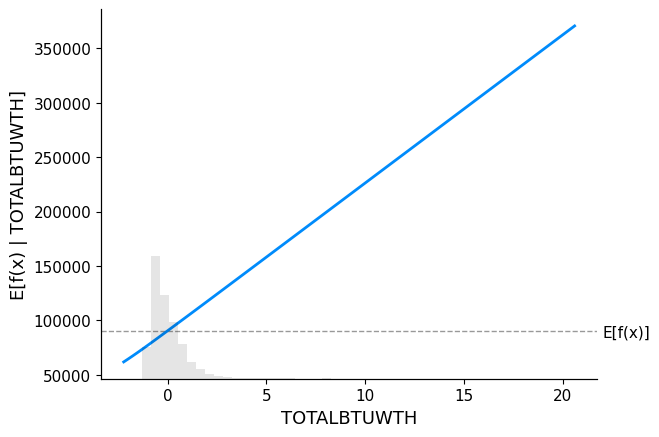

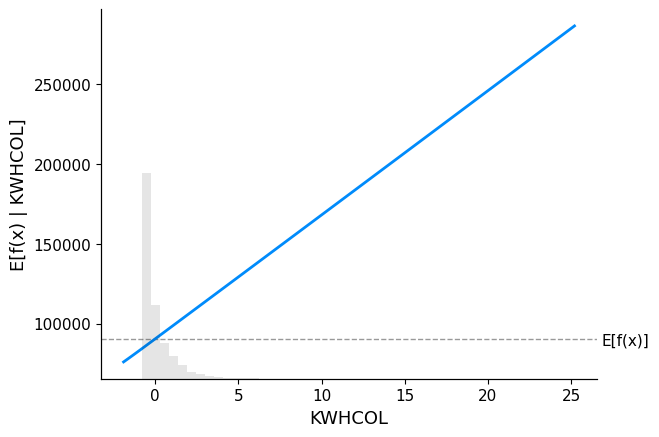

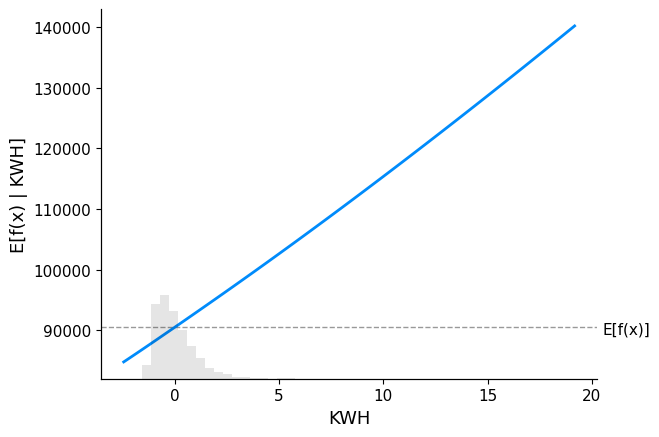

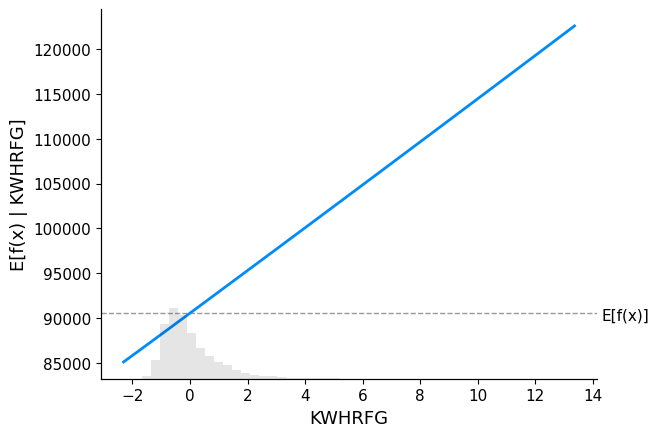

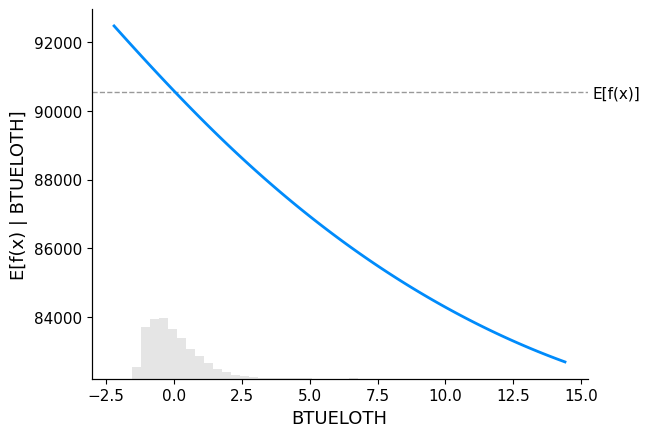

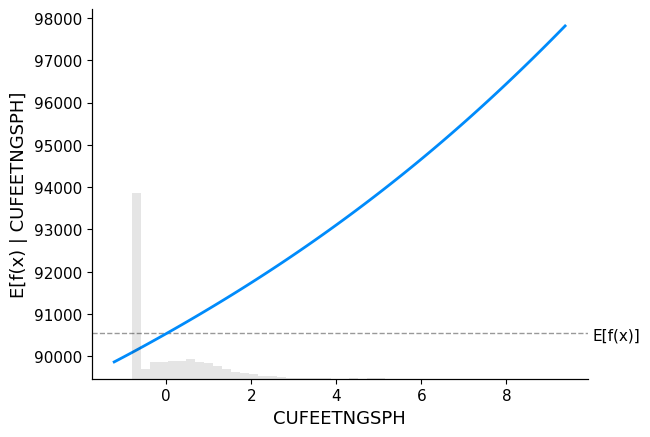

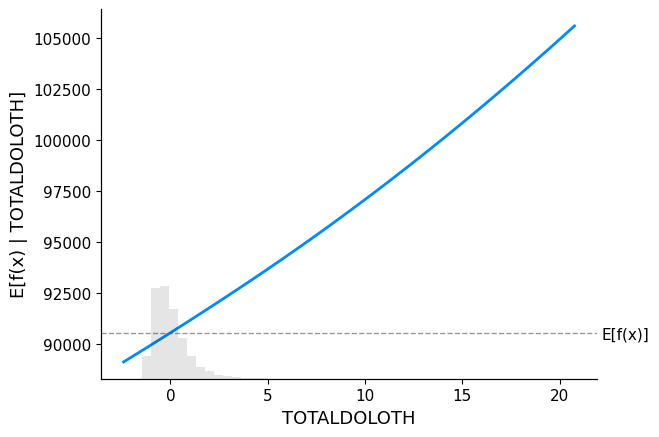

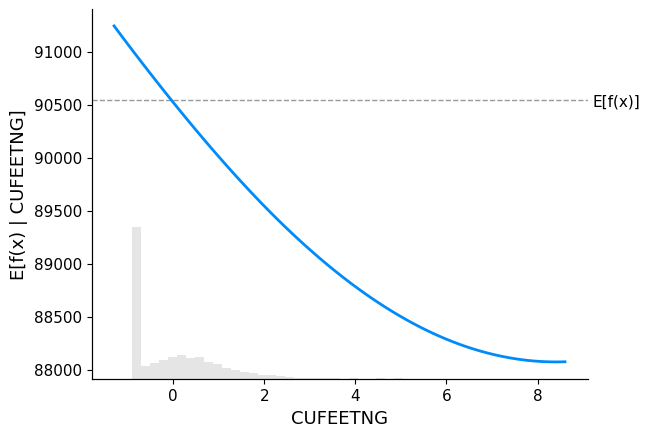

In [ ]:
for f in top_feature_names:

  shap.partial_dependence_plot(
      f,
      model.predict,
      X_train,
      feature_names=feature_names,
      ice=False,
      model_expected_value=True,
      show=False
  )

In [ ]:
np_df = pd.DataFrame(data=X_train, columns=feature_names)
np_df

,Climate_Region_Pub,DIVISION,DOLELCOL,TOTALDOLCOL,KWHCOL,TOTALDOLSPH,TOTALBTUSPH,CELLAR,NWEIGHT,TOTHSQFT,...,BTUNGWTH,TEMPGONE,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,DRYRFUEL,KWHRFG
0,1.036578,0.219759,-0.443681,-0.587200,-0.598909,-0.657250,-0.812947,-1.797688,0.335698,-1.047767,...,-0.733329,0.431116,-0.348648,-0.232623,-0.243256,-0.854868,-0.087470,-0.890190,0.709366,0.266610
1,0.295532,-0.129639,-0.154447,6.957617,5.411170,-1.109910,-1.030969,0.077778,-0.427438,-1.386985,...,1.268532,-4.567013,-0.348648,1.060924,-0.963878,0.665056,2.912822,-2.786530,-0.698235,2.222524
2,-0.445513,1.617350,-0.238778,-0.577543,-0.598501,-0.224356,0.068184,0.077778,-0.476363,-0.463650,...,0.649488,1.125300,-1.200968,0.365507,0.837678,1.647774,-0.536111,-0.510922,0.709366,-0.526514
3,0.295532,0.569157,0.779463,0.854813,0.517600,-0.560393,-0.460316,0.077778,-0.682422,-0.174074,...,0.175606,0.292279,-0.348648,-0.166868,0.477367,-1.590044,-0.451991,0.247614,-0.698235,-0.734657
4,-0.445513,1.267952,1.538439,1.952417,2.666308,-0.862825,-0.909117,0.077778,0.025817,0.242916,...,-0.733329,0.084023,0.503672,-0.300344,1.197989,-0.390240,0.267705,1.764686,0.709366,0.812485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7607,0.295532,0.569157,1.659360,2.242107,2.248244,-0.601903,-0.833102,0.077778,-0.369787,0.747606,...,2.030597,0.569953,-0.348648,1.917050,0.477367,0.300546,1.286496,1.385418,0.709366,1.431591
7608,-1.186559,0.918554,-1.021451,-0.609731,-0.642157,-0.593996,-0.180740,-1.797688,-0.693679,-0.647325,...,-0.063220,0.084023,-0.348648,-0.435131,-2.044811,1.224619,-0.713699,-0.510922,-1.753936,-0.882945
7609,1.036578,0.219759,-1.214505,-0.323260,-0.118141,-0.046455,0.298042,1.015511,0.299778,-0.102921,...,0.552520,-0.263069,1.355993,0.256571,0.477367,-1.559911,-0.442644,1.385418,0.709366,0.274883
7610,1.036578,-1.177831,-0.056526,0.162776,-0.117376,1.720699,1.713565,1.015511,0.356511,-0.083892,...,2.692610,0.431116,0.503672,2.660745,0.477367,0.662140,2.875435,1.385418,-0.698235,1.667524


In [ ]:
from pycebox.ice import ice, ice_plot

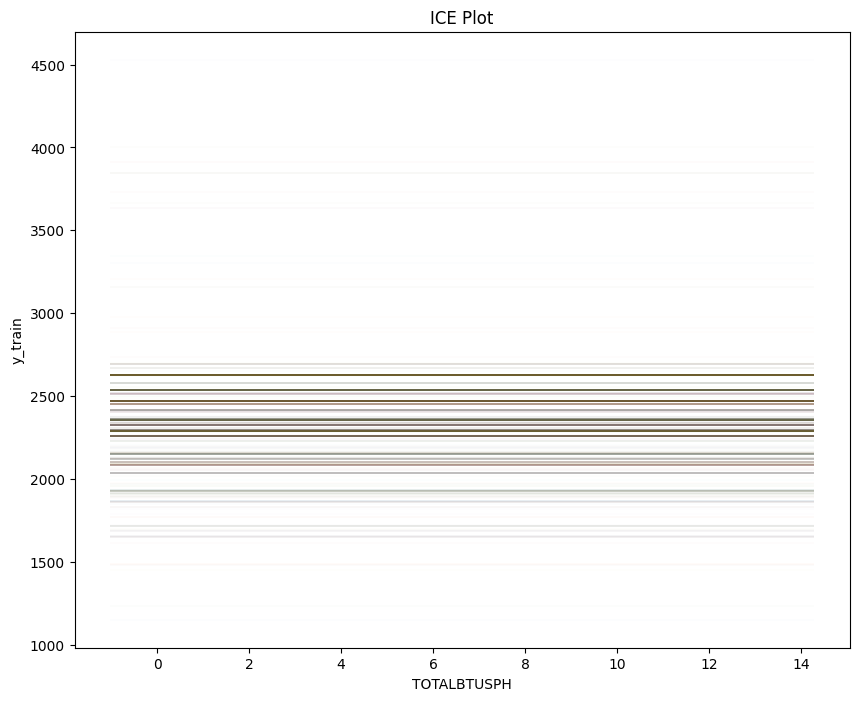

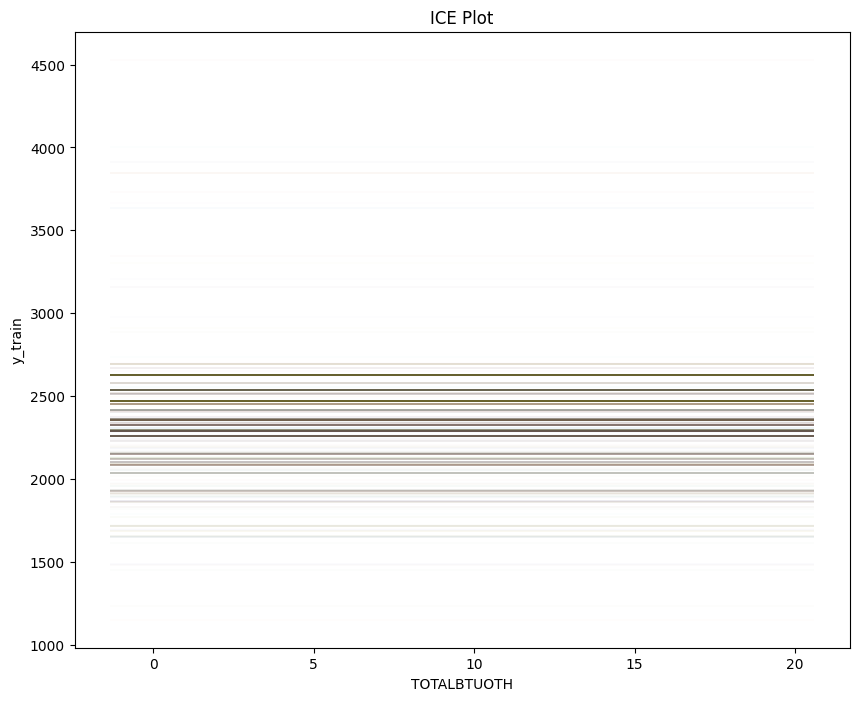

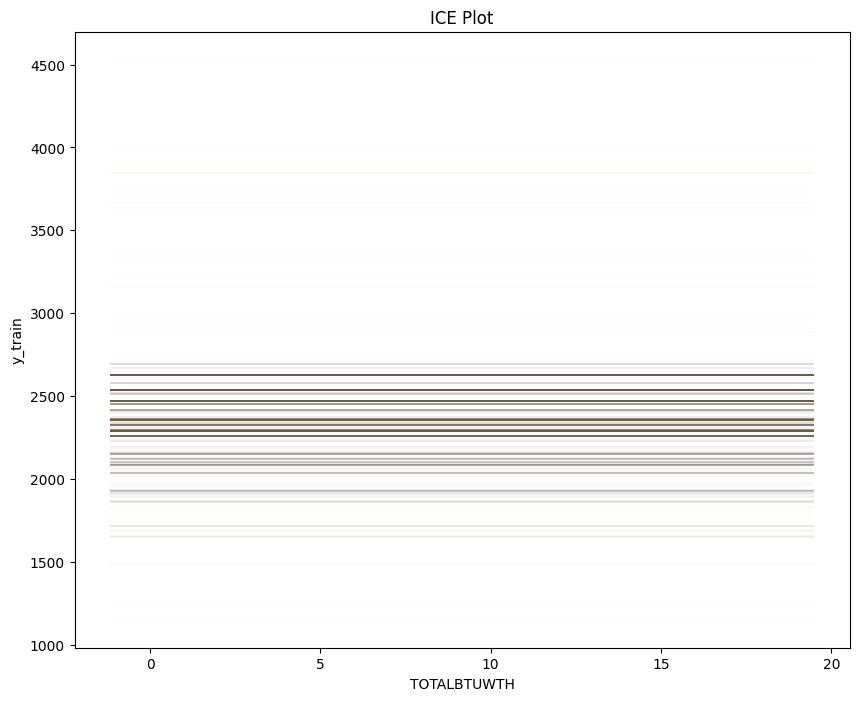

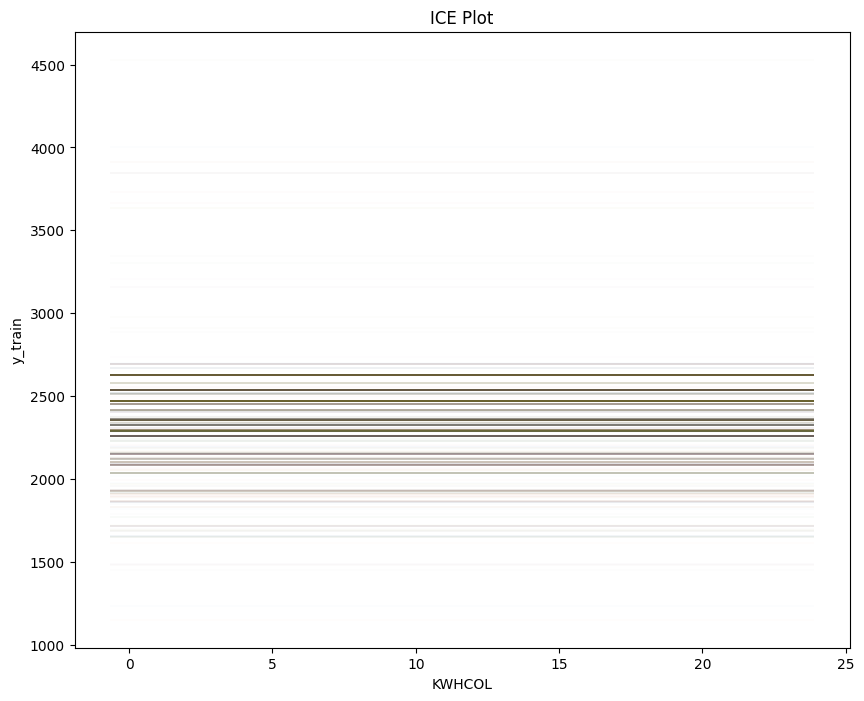

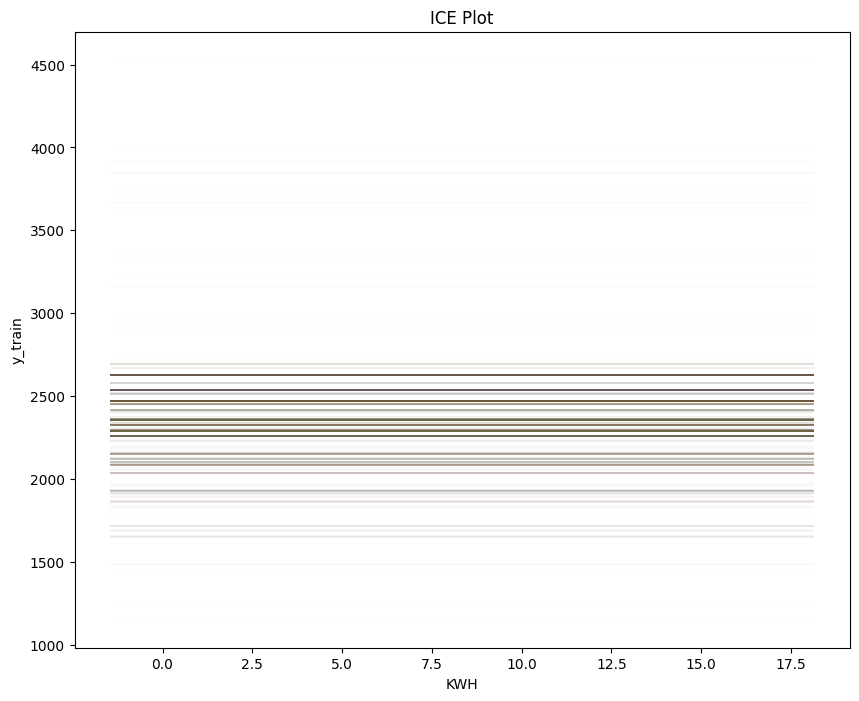

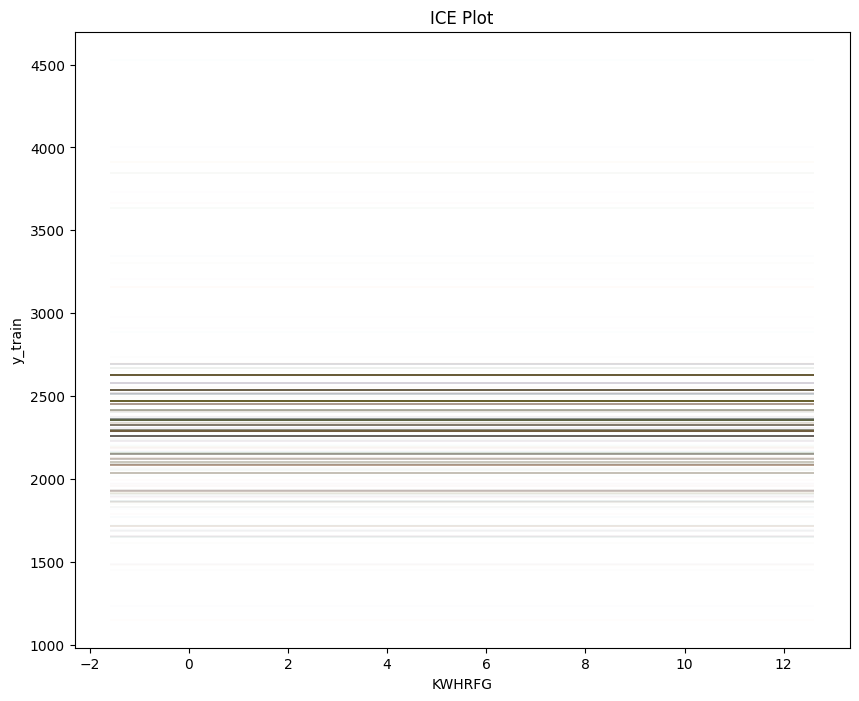

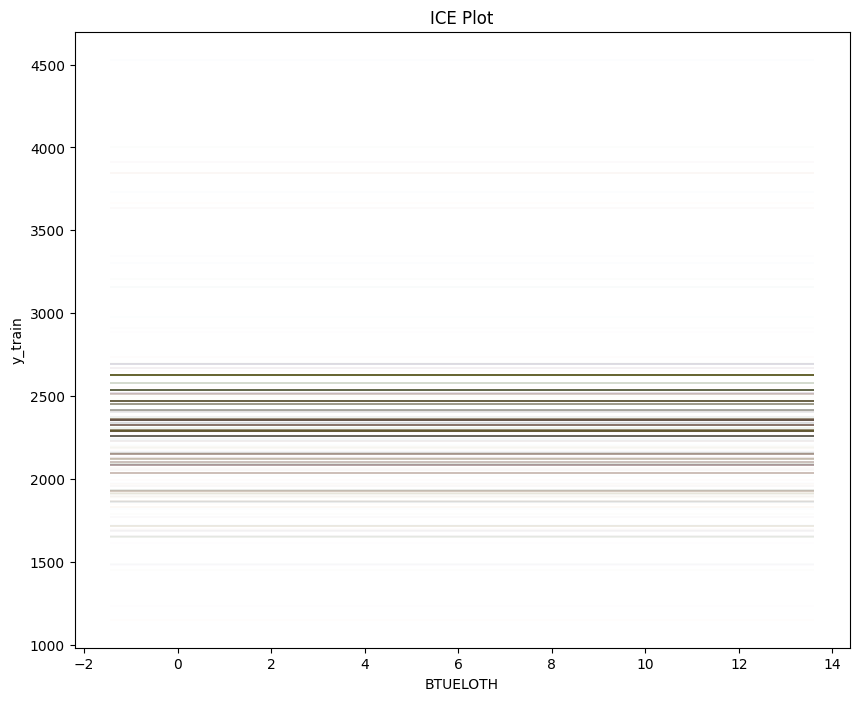

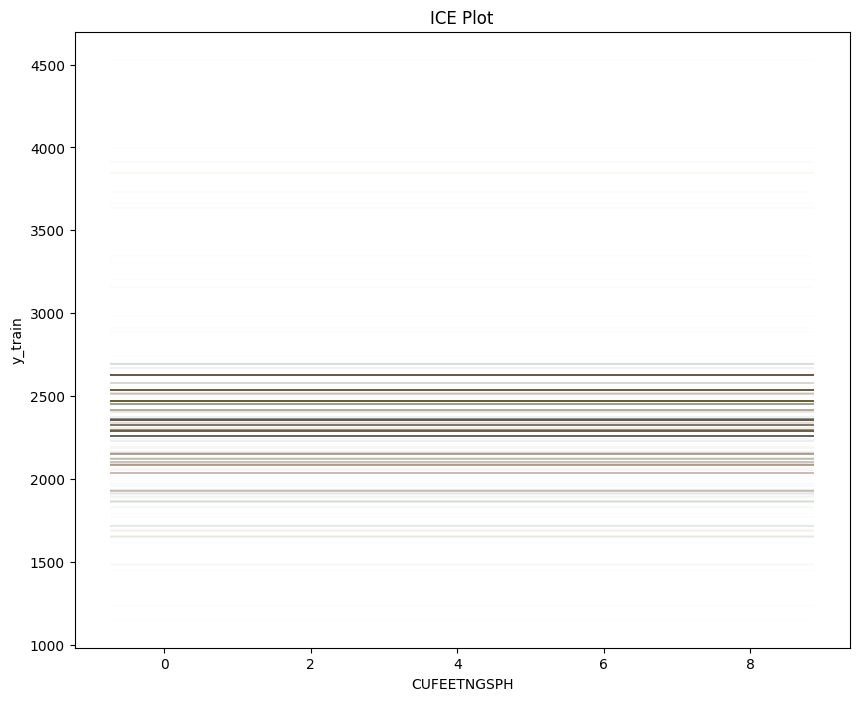

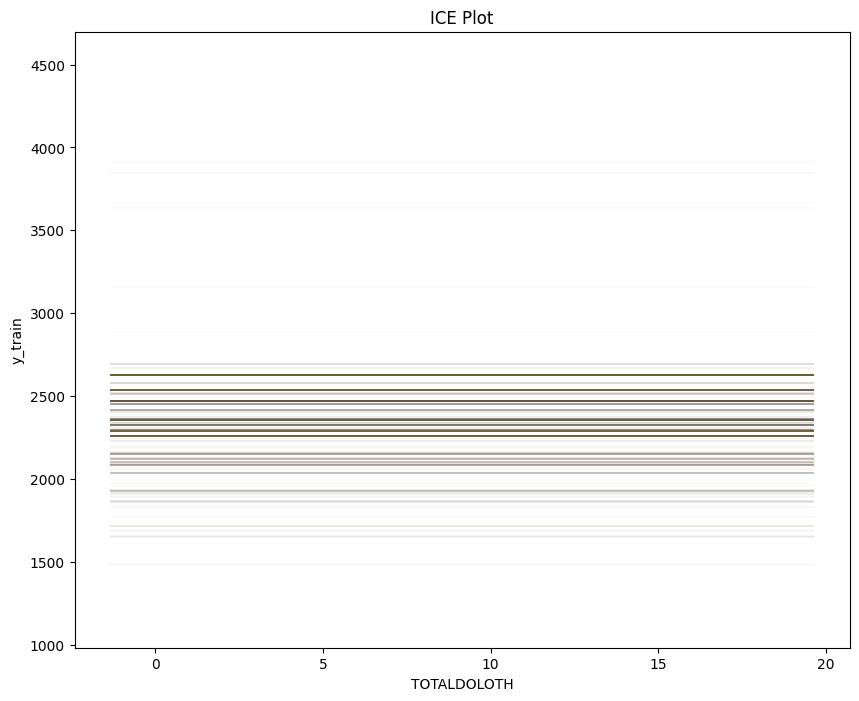

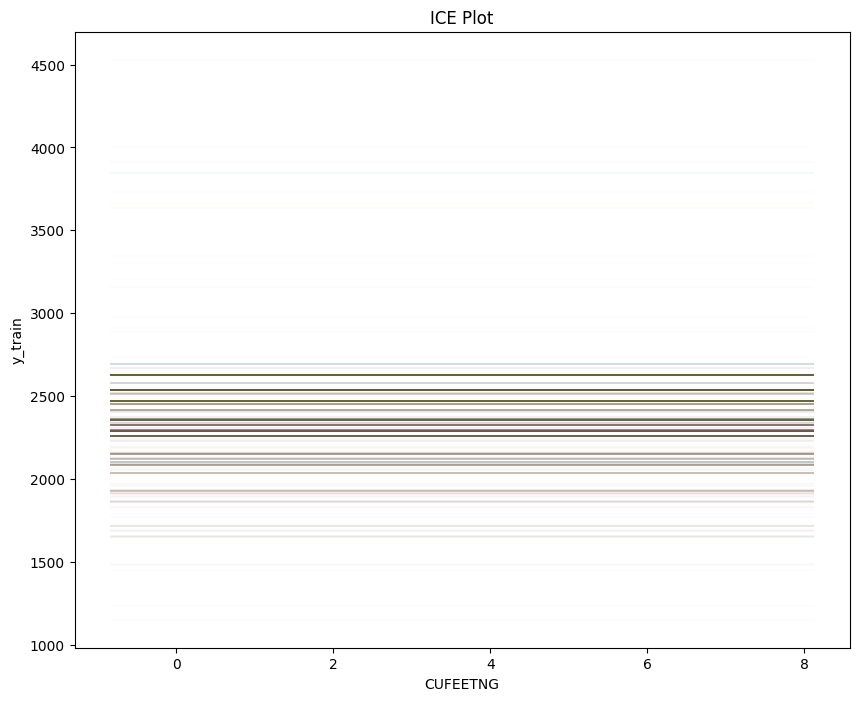

In [ ]:
for feature in top_feature_names:

  ice_df = ice(data = np_df, column = feature, predict = model.predict, num_grid_points=10)

  plt.rcParams['figure.figsize'] = 10,8
  ice_plot(ice_df, linewidth = .15, cmap='PuOr', alpha = 0.1)

  plt.ylabel('y_train')
  plt.xlabel(feature)
  plt.title('ICE Plot')
  plt.show()

In [ ]:
# Выбираем признак для PDP
pd_features = ['KWH', 'COOLTYPE', 'TOTALBTUSPH']

238/238 [==============================] - 0s 2ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='KWH', ylabel='KWH', zlabel='E[f(x) | KWH, KWH]'>)

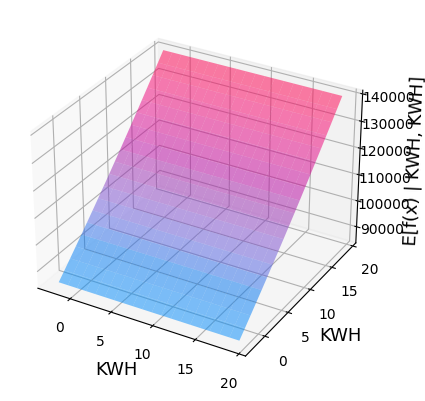

In [ ]:
shap.partial_dependence_plot(
    (pd_features[0], pd_features[0]),
    model.predict,
    X_train,
    feature_names=feature_names,
    ice=True,
    model_expected_value=True,
    show=False
)

238/238 [==============================] - 0s 1ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='KWH', ylabel='COOLTYPE', zlabel='E[f(x) | KWH, COOLTYPE]'>)

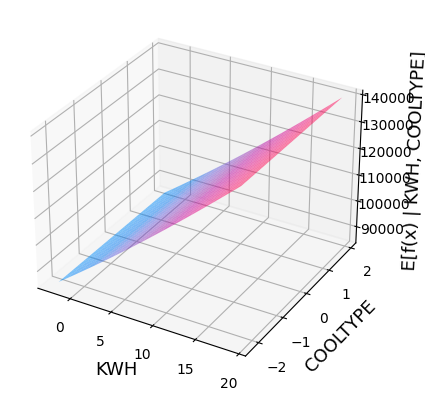

In [ ]:
shap.partial_dependence_plot(
    (pd_features[0], pd_features[1],  pd_features[2]),
    model.predict,
    X_train,
    feature_names=feature_names,
    ice=False,
    model_expected_value=True,
    show=False
)

238/238 [==============================] - 0s 1ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='KWH', ylabel='COOLTYPE', zlabel='E[f(x) | KWH, COOLTYPE]'>)

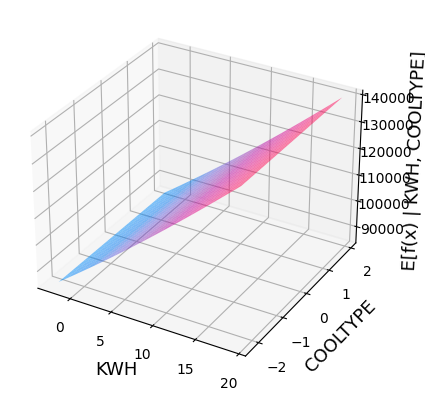

In [ ]:
shap.partial_dependence_plot(
    (pd_features[0], pd_features[1]),
    model.predict,
    X_train,
    feature_names=feature_names,
    ice=True,
    model_expected_value=True,
    show=False
)